In [1]:
#@Imports
import sys
import os
path = os.path.abspath('..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from retry import retry

from language_models.ollama_model import OllamaLanguageModel

from components.components import compute_desire_for_gamble, multiple_choice_preferences, compute_distribution_of_desire_for_gamble, compute_distribution_of_desire_for_gamble_binaries

In [2]:
system_message = ("This is an agent based model. "
  f"The goal of the LLM to to play characters in a game, and act as humanlike as possible. "
  "Ideally, human observers should not be able to tell the difference between the LLM and a human player. "
)

model = OllamaLanguageModel(
"llama3:70b", system_message=system_message, streaming=False
)

In [3]:
expected_values = []
attitudes = []
attitudes2 = []

for i in range(500):
  # Simulate decision making for each player.
  Good_value = np.random.choice(np.arange(10))
  Bad_value = np.random.choice(np.arange(10))
  P_w = np.random.choice(np.arange(10) / 10)

  # Compute the expected value of the gamble.
  expected_value = P_w * Good_value + (1 - P_w) * -1*Bad_value
  gamble_input = f"Probability of Winning (P_w): {P_w}, Positive Value on Win (G): {Good_value}, Negative Value on Loss (B): {-Bad_value}"
  # Compute affective LLM value estimate
  value_samples = []
  for sample in range(10):
    llm_value = compute_desire_for_gamble(model, gamble_input)
    value_samples.append(llm_value)
    #print(value_samples)
  llm_values = np.mean(value_samples)

  expected_values.append(expected_value)
  attitudes.append(llm_values)
  #takepass =  multiple_choice_preferences(model, None, gamble_input, llm_value)
  dist, expected_value_est = compute_distribution_of_desire_for_gamble(model, gamble_input)
  attitudes2.append(expected_value_est)

  use_multiple_choice_tests = False # these are not working yet
  if use_multiple_choice_tests:
    original_probabilities, softmax_probabilities = compute_distribution_of_desire_for_gamble_binaries(model, gamble_input)
    print("yes/no outputs: ", original_probabilities)
    print("softmax of yes/ne: ", softmax_probabilities)

  # Print trial outputs
  clear_output(wait = True)
  print(gamble_input)
  print(f"╔════════════════╗")
  print(f"║   {'Trial ' + str(i+1)+':':<10}   ║")
  print(f"╠════════════════╣")
  print(f"║  EV:    {round(expected_value, 2):<6} ║")
  print(f"║  Value: {round(llm_values, 2):<6} ║")
  print(f"║  dValue: {round(expected_value, 2):<6} ║")
  print(f"╚════════════════╝")
  print(value_samples)
  print(dist)



TypeError: range() takes no keyword arguments

/Users/wil/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


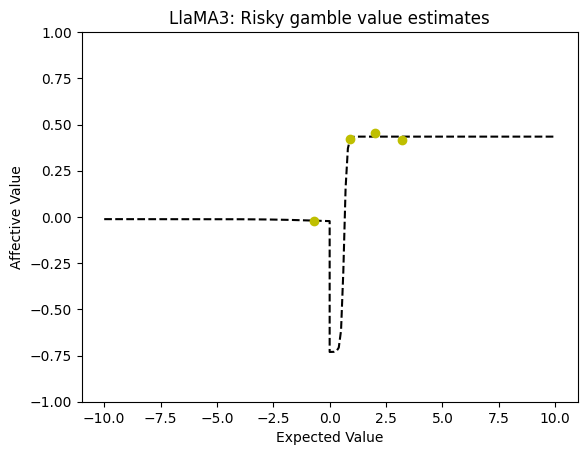

In [ ]:
%autoreload 2
from components.prospect_theory import curve_fit, plot_curve

outcomes = curve_fit(expected_values, attitudes)
plot_curve(*outcomes, expected_values, attitudes, title = "LlaMA3: Risky gamble value estimates")